## Imports

In [73]:
import os
import re
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

# Ensure inline plotting for notebooks
%matplotlib inline

## Configuration

In [89]:
# ----------------- USER CONFIGURATION -----------------

# 1. Where are the images located?
base_path = "/home/phd2/Documenti/embryo/embryo_to_send_gradcam/correct_blasto/ConvTran/D2015.11.03_S1380_I141_2/overlay_farneback"

# 2. What is the common start of the filenames? 
# (e.g. if file is "flow_D2015...jpg", put "flow_D2015")
file_prefix = "flow_D2015.11.03_S1380_I141_2"

# 3. What are the 5 starting frame NUMBERS? (Integers only)
start_frames = [8, 103, 157, 323, 477]      # 1.8h, 25.9, 39.4, 81.1h, 119.8h

# 4. Output settings
save_path = "/home/phd2/Documenti/embryo/mosaic_5x5.png"
tile_size = 512
sequence_length = 5  # How many frames per row
label_height = 70    # Slightly taller for fancier fonts
font_size = 42       # Larger font size

# 5. Aesthetic settings
bg_color = (0, 0, 0)       # Black background
text_color = (255, 255, 255) # White text
placeholder_bg = (40, 40, 40) # Dark gray for missing image slots

# ------------------------------------------------------

## Helpers

In [90]:
def get_frame_index(filename):
    """Extracts the frame number from the filename."""
    match = re.search(r'_(\d+)_0_', filename)
    if match:
        return int(match.group(1))
    return None

def get_timing_label(filename):
    """Extracts the timing (e.g., "32.6h") from the end of the filename."""
    match = re.search(r'_([0-9]+\.[0-9]+h)(?=\.[^\.]+$)', filename)
    if match:
        return match.group(1)
    return "N/A"

def map_folder_indices(path, prefix):
    """Scans the folder and returns a dict: {frame_number: full_filename}"""
    if not os.path.isdir(path):
        raise FileNotFoundError(f"Directory not found: {path}")

    index_map = {}
    valid_files = [f for f in os.listdir(path)
                   if f.startswith(prefix)
                   and f.lower().endswith(('.jpg', '.png', '.jpeg', '.tif', '.tiff'))]

    for fname in valid_files:
        idx = get_frame_index(fname)
        if idx is not None:
            index_map[idx] = fname

    return index_map

def center_crop_resize(img, target_size):
    w, h = img.size
    side = min(w, h)
    left = (w - side) // 2
    top = (h - side) // 2
    cropped = img.crop((left, top, left + side, top + side))
    return cropped.resize((target_size, target_size), Image.LANCZOS)

def get_font(size):
    """Tries to load a non-italic fancy font, falls back to standard ones."""
    # List of potential non-italic fancy/display fonts to try
    fancy_fonts = [
        "DejaVuSansDisplay.ttf",  # Nice non-serif display font
        "FreeSans.ttf",           # Standard sans-serif
        "arial.ttf",              # Common Windows font
        "times.ttf",              # Common serif font
        "URWChanceryL-Medi.ttf",  # Non-italic version of previous
    ]

    for font_name in fancy_fonts:
        try:
            # Check for non-italic variants first
            return ImageFont.truetype(font_name.replace('Ital', ''), size)
        except IOError:
            try:
                return ImageFont.truetype(font_name, size)
            except IOError:
                continue

    print("Warning: Could not load desired TTF font, falling back to default.")
    return ImageFont.load_default() # Final fallback

def draw_centered_text(bg_image, text_str, area_top_y, area_height, font):
    """Helper to draw text centered horizontally and vertically within a defined zone."""
    draw = ImageDraw.Draw(bg_image)
    img_width = bg_image.width

    # Calculate text bounding box
    bbox = draw.textbbox((0, 0), text_str, font=font)
    text_w = bbox[2] - bbox[0]
    text_h = bbox[3] - bbox[1]

    pos_x = (img_width - text_w) / 2
    # align at top within the label area
    pos_y = area_top_y

    draw.text((pos_x, pos_y), text_str, fill=text_color, font=font)

def get_placeholder_font(size):
    """Gets a standard font for placeholder text, avoiding the fancy font issues."""
    try:
        return ImageFont.truetype("DejaVuSans.ttf", size)
    except IOError:
        return ImageFont.load_default()

def create_placeholder(img_size, label_h, main_label, timing_label, font_main, font_timing):
    """Creates a placeholder tile with a dark image area and label below."""
    full_h = img_size[1] + label_h
    
    # Use standard placeholder font for readability
    ph_font_main = get_placeholder_font(20)

    # Create dark placeholder for image part
    img_part = Image.new("RGB", img_size, placeholder_bg)
    draw_img = ImageDraw.Draw(img_part)
    # Use a reddish color for the "Missing" warning so it stands out
    draw_img.text((20, 20), "Missing Frame", fill=(220, 50, 50), font=ph_font_main)
    draw_img.text((20, 50), main_label, fill=(180, 180, 180), font=ph_font_main)

    # Create full tile canvas with black background
    full_tile = Image.new("RGB", (img_size[0], full_h), bg_color)
    # Paste image part at top
    full_tile.paste(img_part, (0,0))
    
    # Draw timing label below if available
    if timing_label != "N/A":
        draw_centered_text(full_tile, timing_label, img_size[1], label_h, font_timing)
        
    return full_tile

## Execute

Scanning directory: /home/phd2/Documenti/embryo/embryo_to_send_gradcam/correct_blasto/ConvTran/D2015.11.03_S1380_I141_2/overlay_farneback...
Found 556 valid images matching prefix 'flow_D2015.11.03_S1380_I141_2'
Processing Row 1: Starting at frame 8
Processing Row 2: Starting at frame 103
Processing Row 3: Starting at frame 157
Processing Row 4: Starting at frame 323
Processing Row 5: Starting at frame 477

Saved mosaic to: /home/phd2/Documenti/embryo/mosaic_5x5.png


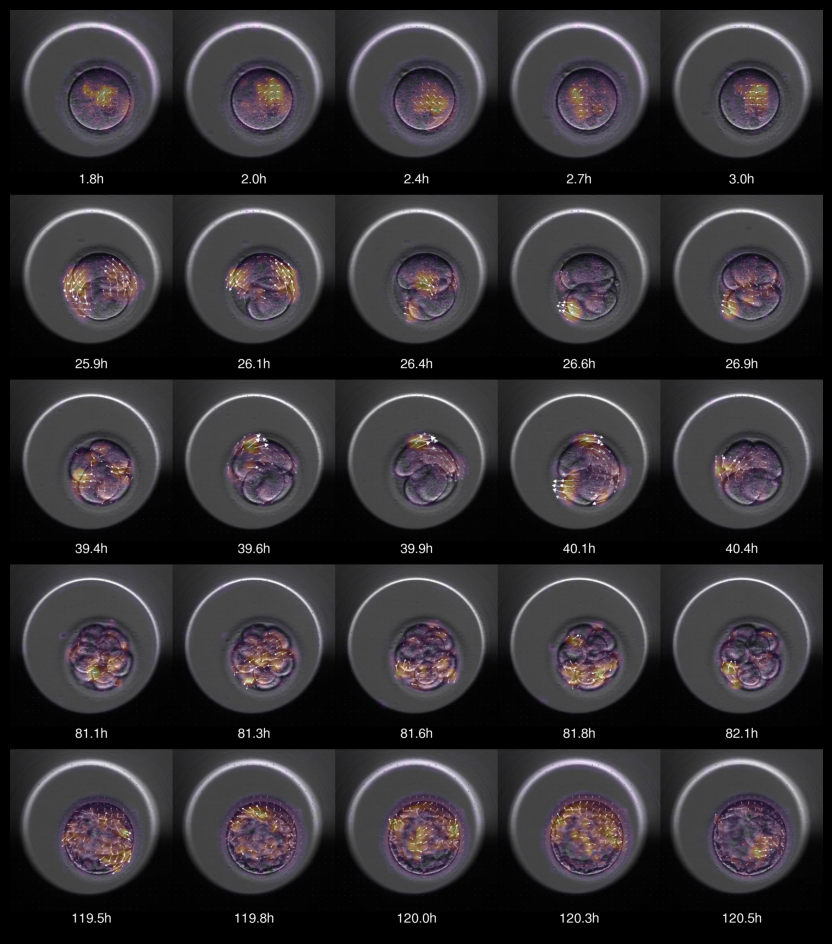

In [91]:
def generate_labeled_mosaic():
    print(f"Scanning directory: {base_path}...")

    # 1. Map existing files by index
    file_map = map_folder_indices(base_path, file_prefix)
    print(f"Found {len(file_map)} valid images matching prefix '{file_prefix}'")

    # Load fonts
    timing_font = get_font(font_size)
    placeholder_font = get_placeholder_font(20)

    # Calculate dimensions
    row_height = tile_size + label_height
    mosaic_w = sequence_length * tile_size
    mosaic_h = len(start_frames) * row_height

    # Create main canvas with BLACK background
    mosaic = Image.new("RGB", (mosaic_w, mosaic_h), bg_color)

    # 2. Iterate rows
    for row_idx, start_num in enumerate(start_frames):
        print(f"Processing Row {row_idx+1}: Starting at frame {start_num}")
        y_pos = row_idx * row_height

        # 3. Iterate columns
        for col_idx in range(sequence_length):
            current_frame_num = start_num + col_idx
            x_pos = col_idx * tile_size

            fname = file_map.get(current_frame_num)
            
            # Create tile canvas with BLACK background
            tile_canvas = Image.new("RGB", (tile_size, row_height), bg_color)
            timing_str = "N/A"

            if fname:
                full_path = os.path.join(base_path, fname)
                timing_str = get_timing_label(fname)
                try:
                    img = Image.open(full_path).convert("RGB")
                    img_resized = center_crop_resize(img, tile_size)
                    # Paste image at top of tile canvas
                    tile_canvas.paste(img_resized, (0, 0))
                    # Draw label below
                    draw_centered_text(tile_canvas, timing_str, tile_size, label_height, timing_font)
                except Exception as e:
                    print(f"  Error reading {fname}: {e}")
                    # Use placeholder function for errors too
                    tile_canvas = create_placeholder((tile_size, tile_size), label_height,
                                                     f"Err: {fname}", timing_str, placeholder_font, timing_font)
            else:
                # Frame missing
                tile_canvas = create_placeholder((tile_size, tile_size), label_height,
                                                 f"Fr {current_frame_num} not found", timing_str, placeholder_font, timing_font)

            # Paste the finished combined tile into the main mosaic
            mosaic.paste(tile_canvas, (x_pos, y_pos))

    # 4. Save and Show
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    mosaic.save(save_path, dpi=(300, 300))
    print(f"\nSaved mosaic to: {save_path}")

    # Display with a dark background for the plot figure itself
    fig = plt.figure(figsize=(12, 12))
    fig.patch.set_facecolor('black') 
    ax = plt.axes()
    ax.set_facecolor('black')
    plt.axis("off")
    plt.imshow(mosaic)
    plt.show()

# Run the process
generate_labeled_mosaic()